In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
DATASET_PATH = r"stage1_train 2"

In [3]:
def load_sample(sample_path):
    image_folder = os.path.join(sample_path, "images")
    mask_folder = os.path.join(sample_path, "masks")
    if not os.path.isdir(image_folder):
        return None, None
    if not os.path.isdir(mask_folder):
        return None, None
    image_files = [f for f in os.listdir(image_folder)if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
    if len(image_files) == 0:
        return None, None
    image_path = os.path.join(image_folder, image_files[0])
    image = cv2.imread(image_path)
    if image is None:
        return None, None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    mask_files = [f for f in os.listdir(mask_folder)if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
    if len(mask_files) == 0:
        return None, None
    for mask_file in mask_files:
        mask_path = os.path.join(mask_folder, mask_file)
        m = cv2.imread(mask_path, 0)
        if m is not None:
            mask[m > 0] = 1
    return image, mask

In [4]:
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel, iterations=2)
    return closing

In [5]:
def watershed_without_markers(image):
    binary = preprocess(image)
    _, thresh = cv2.threshold(binary, 0, 255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    sure_bg = cv2.dilate(thresh, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(
        thresh, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    _, sure_fg = cv2.threshold(dist_transform,0.7 * dist_transform.max(),255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image.copy(), markers)
    return markers, dist_transform

In [6]:
def watershed_with_markers(image, marker_erosion=2):
    binary = preprocess(image)
    _, thresh = cv2.threshold(binary, 0, 255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    sure_bg = cv2.dilate(thresh, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    _, sure_fg = cv2.threshold(dist_transform,0.9 * dist_transform.max(),255, 0)
    sure_fg = np.uint8(sure_fg)
    sure_fg = cv2.erode(sure_fg, kernel, iterations=marker_erosion)
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image.copy(), markers)
    return markers, dist_transform

In [7]:
def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2 * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-6)

In [8]:
def over_segmentation_metric(ground_truth, predicted):
    gt_labels = cv2.connectedComponents(ground_truth.astype(np.uint8))[0] - 1
    pred_labels = len(np.unique(predicted)) - 2
    ratio = pred_labels / (gt_labels + 1e-7)
    return ratio, gt_labels, pred_labels


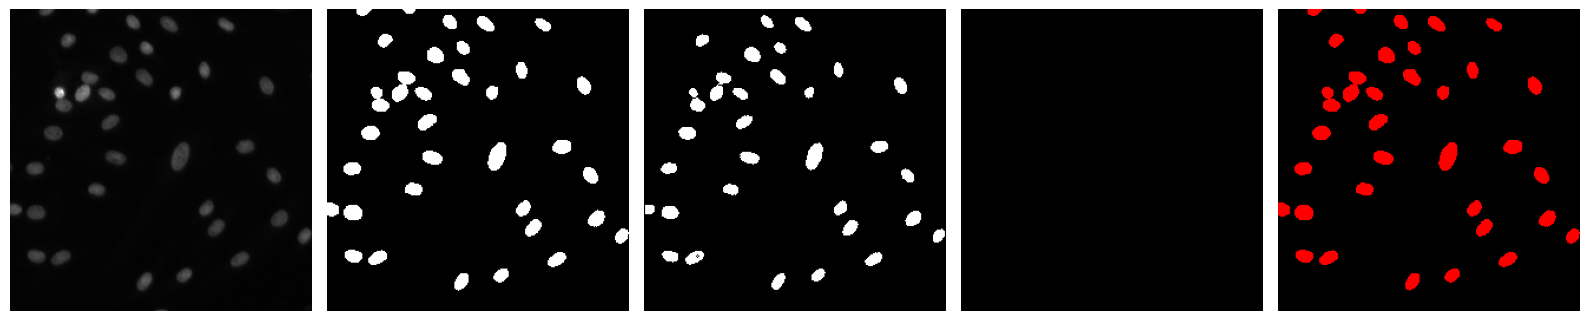

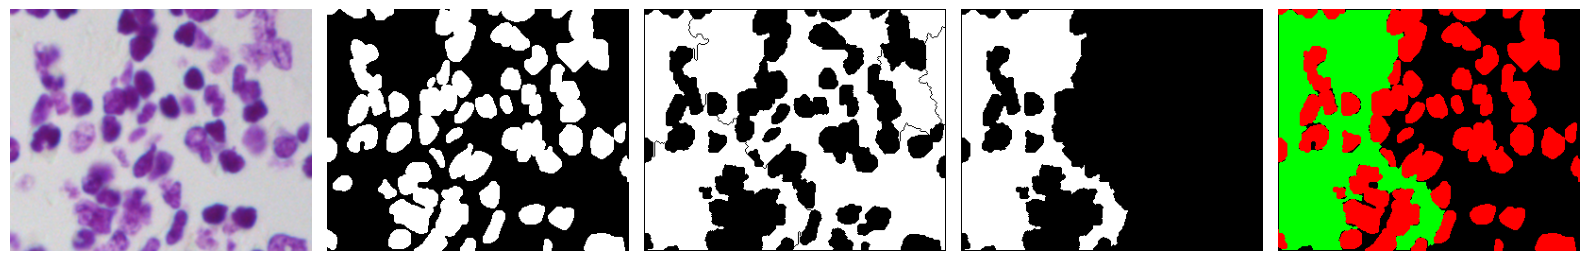

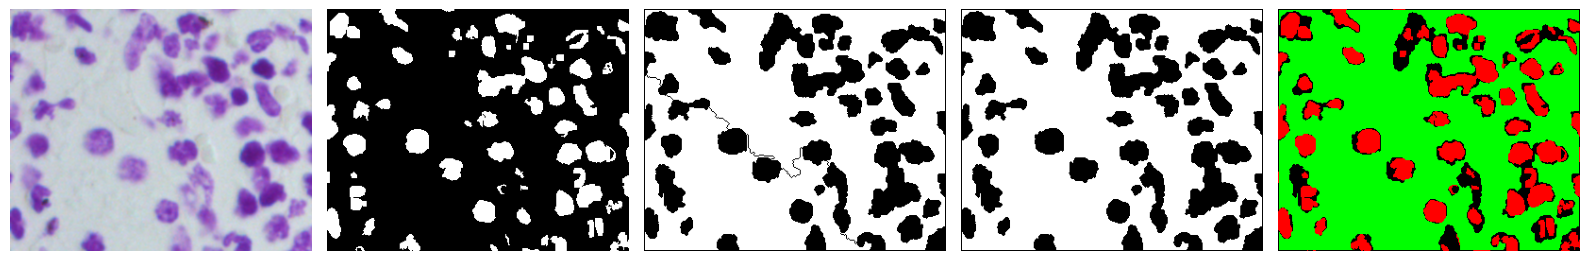

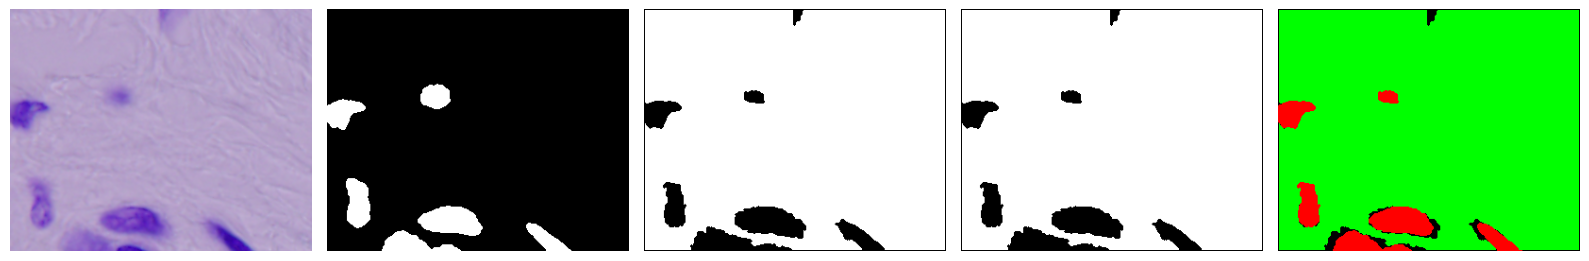

Samples processed: 4
Average Dice (No Markers): 0.24070920374322075
Average Dice (With Markers): 0.023604848618556728
Average Over-seg (No Markers): 0.34322916511534607
Average Over-seg (With Markers): 0.051822915950493716


In [9]:
samples = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
dice_no_marker = []
dice_marker = []
over_seg_no_marker = []
over_seg_marker = []
count = 0
for sample in samples[:5]:
    sample_path = os.path.join(DATASET_PATH, sample)
    image, gt_mask = load_sample(sample_path)
    if image is None or gt_mask is None:
        continue
    count += 1
    pred1, dist1 = watershed_without_markers(image)
    pred2, dist2 = watershed_with_markers(image, marker_erosion=2)
    pred1_binary = (pred1 > 1).astype(np.uint8)
    pred2_binary = (pred2 > 1).astype(np.uint8)
    d1 = dice_score(gt_mask, pred1_binary)
    d2 = dice_score(gt_mask, pred2_binary)
    dice_no_marker.append(d1)
    dice_marker.append(d2)
    ratio1, gt_nuclei, pred1_nuclei = over_segmentation_metric(gt_mask, pred1)
    ratio2, _, pred2_nuclei = over_segmentation_metric(gt_mask, pred2)
    over_seg_no_marker.append(ratio1)
    over_seg_marker.append(ratio2)
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 5, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.subplot(1, 5, 2)
    plt.imshow(gt_mask, cmap="gray")
    plt.axis("off")
    plt.subplot(1, 5, 3)
    plt.imshow(pred1_binary, cmap="gray")
    plt.axis("off")
    plt.subplot(1, 5, 4)
    plt.imshow(pred2_binary, cmap="gray")
    plt.axis("off")

    comparison = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    comparison[gt_mask == 1] = [255, 0, 0]
    comparison[pred2_binary == 1] = [0, 255, 0]

    plt.subplot(1, 5, 5)
    plt.imshow(comparison)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

print("Samples processed:", count)

if count > 0:
    print("Average Dice (No Markers):", np.mean(dice_no_marker))
    print("Average Dice (With Markers):", np.mean(dice_marker))
    print("Average Over-seg (No Markers):", np.mean(over_seg_no_marker))
    print("Average Over-seg (With Markers):", np.mean(over_seg_marker))
